# Sentiment analysis using LSTM


## Step 1: Data exploration and preprocessing

Importing neccessary libraries

In [157]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
import time
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
from itertools import product
from sklearn.model_selection import ParameterGrid

# Load JSON Data
import json
import pandas as pd
import torch
import nltk
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
import sklearn
import optuna

[nltk_data] Downloading package punkt to /user/dsivaram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1. Load your chosen dataset and print the main statistics

In [256]:
file_path = "News_Category_Dataset_v3.json"
df = pd.read_json(file_path, lines=True)


### Main Statistics

In [258]:
df.describe()

/scratch/18974108/ipykernel_2456410/3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [161]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [162]:
df.columns

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

2. Print the first 5 rows of the dataset to understand its structure

In [163]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


3. Provide a brief description of the dataset

<span style='color:green'>


This dataset consists of 209,527 news articles collected from HuffPost, covering various topics and categories such as U.S. News, Politics, and Comedy. Each article entry contains six key attributes, the article's headline, the specific category it belongs to, a short textual summary, author names, and the publication date. The dataset spans multiple publication dates and is particularly suitable for natural language processing tasks, including sentiment analysis, classification, and content summarization. 

Dataset Source: Kaggle 

Link: https://www.kaggle.com/datasets/rmisra/news-category-dataset
</span>

4. Display descriptive statistics

In [257]:
print(f"Total number of samples: {len(df)}")

Total number of samples: 209527


In [164]:
def get_sentiment(category):
    positive = ['ENTERTAINMENT', 'CULTURE & ARTS', 'SPORTS', 'COMEDY']
    negative = ['U.S. NEWS', 'WORLD NEWS', 'POLITICS', 'ENVIRONMENT']
    if category in positive:
        return 'positive'
    elif category in negative:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['category'].apply(get_sentiment)

Class Distribution

In [165]:
class_distribution = df['sentiment'].value_counts(normalize=True) * 100

In [260]:
print("Class Distribution")
class_distribution

Class Distribution


neutral     66.288354
negative    19.912470
positive    13.799176
Name: sentiment, dtype: float64

Average review length

In [167]:
df['headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))

In [168]:
df.describe()

,headline_word_count
count,209527.000000
mean,9.600744
std,3.068507
min,0.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,44.000000


In [169]:
avg_word_count = df['headline_word_count'].mean()
print("Average Word Count:", avg_word_count)

Average Word Count: 9.600743579586402


Vocabulary Size 

In [170]:
vocabulary = set()
for headline in df['headline']:
    vocabulary.update(headline.split())
vocabulary_size = len(vocabulary)

In [259]:
print("Vocabulary Size: ",vocabulary_size)

Vocabulary Size:  123158


5. Handle missing values

In [172]:
df.isnull().sum()

link                   0
headline               0
category               0
short_description      0
authors                0
date                   0
sentiment              0
headline_word_count    0
dtype: int64

<span style='color:green'>

The dataset has been checked for missing values, and there are no null values present. All the columns have complete data and are ready for further analysis.

</span>

6. Create visualizations to gain insights into the data

### Visualization 1 - Histogram of review lengths (words). 

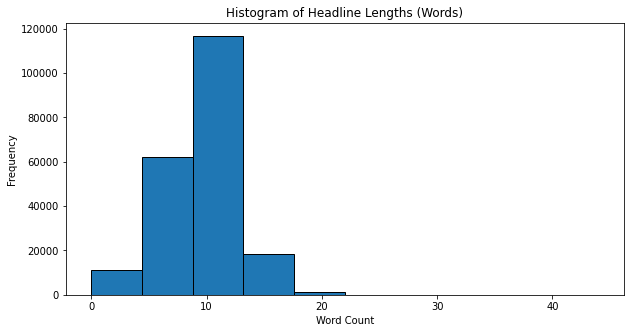

In [173]:
plt.figure(figsize=(10, 5))
plt.hist(df['headline_word_count'], bins=10, edgecolor='black')
plt.title('Histogram of Headline Lengths (Words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

<span style='color:green'>The histogram shows that most headlines are between 5 to 15 words, with a peak at around 10 words. Very few headlines have more than 20 words. This suggests that simple and short titles are more common.</span>

### Visualization 2 - Word clouds for each sentiment class

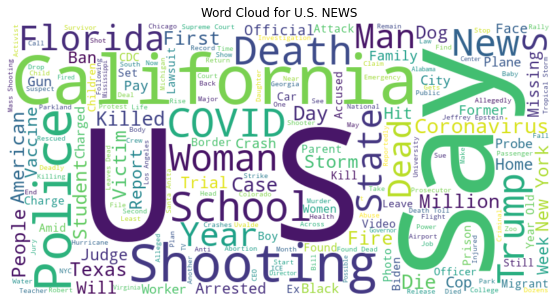

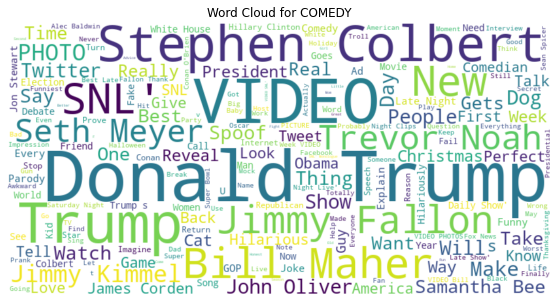

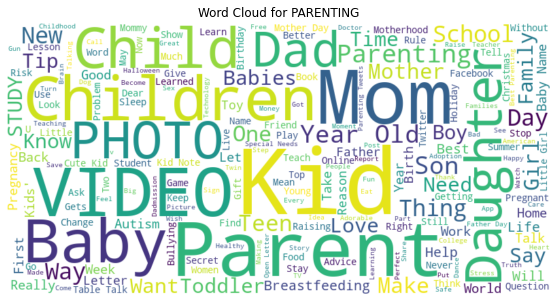

In [174]:
categories = df['category'].unique()
categories = categories[:3]
for category in categories:
    text = ' '.join(df[df['category'] == category]['headline'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

<span style='color:green'>

1.⁠ ⁠*U.S. NEWS:* Words like "US," "say," "COVID," "police," and "death" appear a lot, showing that news is mostly focused on national issues, the pandemic, law enforcement, and serious incidents.

2.⁠ ⁠*COMEDY:* Terms such as "Donald Trump," "Stephen Colbert," "video," and "SNL" are quite common, suggesting that comedy content often revolves around political satire and well-known personalities.

3.⁠ ⁠*PARENTING:* Words like "parent," "video," "child," "mom," and "baby" stand out, indicating that most topics are about family life, parenting tips, and relatable experiences for parents.
    
</span>

### Visualization 3 - Category Distribution Bar chart

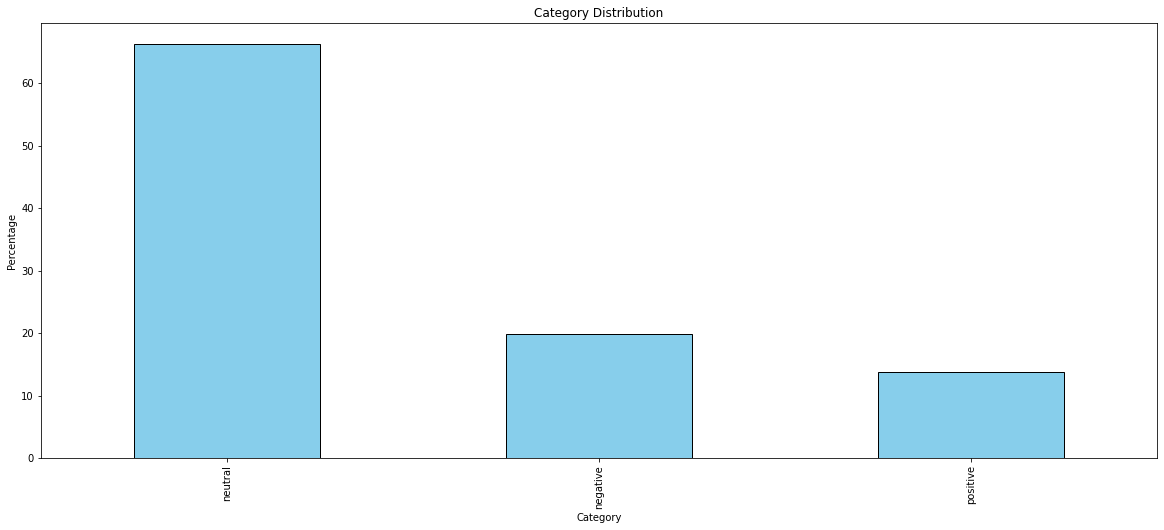

In [175]:
plt.figure(figsize=(20, 8))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

<span style='color:green'>The chart shows that most of the data is in the "neutral" category, making up more than 60%, while the "negative" and "positive" categories have much smaller shares. This imbalance means that neutral content is a lot more common, which might make it harder for a sentiment analysis model to accurately detect positive or negative sentiments.</span>

7. Data preparation

#### i. Handle categorical Data

In [176]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [177]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### ii. Handle class distribution imbalance

In [178]:
class_counts = df['label'].value_counts().sort_index()
total_samples = len(df)
class_weights = torch.tensor([total_samples / count for count in class_counts], dtype=torch.float).to(device)

#### iii. Tokenize the data

##### Using NLTK

In [179]:
start_nltk = time.time()
tokens_nltk = [nltk.word_tokenize(text) for text in df['headline']]
end_nltk = time.time()

##### Using BERT (Hugging Face)

In [180]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
start_bert = time.time()
tokens_bert = [tokenizer.tokenize(text) for text in df['headline']]
end_bert = time.time()

#### iv. Building Vocubulary 

Using NLTK 

In [181]:
vocab_nltk = {token for tokens in tokens_nltk for token in tokens}
vocab_nltk = {word: idx + 1 for idx, word in enumerate(vocab_nltk)}

Using BERT

In [182]:
vocab_bert = {token for tokens in tokens_bert for token in tokens}
vocab_bert = {word: idx + 1 for idx, word in enumerate(vocab_bert)}

#### v. Pad Sequences

In [183]:
sequences_nltk = [[vocab_nltk[token] for token in tokens] for tokens in tokens_nltk]
sequences_bert = [[vocab_bert[token] for token in tokens] for tokens in tokens_bert]

In [184]:
max_length = int(np.percentile([len(seq) for seq in sequences_nltk], 95))

In [185]:
padded_nltk = np.array([seq[:max_length] + [0] * (max_length - len(seq)) if len(seq) < max_length else seq[:max_length] for seq in sequences_nltk])
padded_bert = np.array([seq[:max_length] + [0] * (max_length - len(seq)) if len(seq) < max_length else seq[:max_length] for seq in sequences_bert])

#### vi. Extract Labels

In [186]:
labels = df['label'].values

### Compare NLTK and BERT

In [187]:
tokenization_times = (end_nltk - start_nltk, end_bert - start_bert)
vocab_sizes = (len(vocab_nltk), len(vocab_bert))
padded_shapes = (padded_nltk.shape, padded_bert.shape)

In [188]:
print(f"Tokenization Times (NLTK, BERT): {tokenization_times}")
print(f"Vocabulary Sizes (NLTK, BERT): {vocab_sizes}")
print(f"Padded Shapes (NLTK, BERT): {padded_shapes}")

Tokenization Times (NLTK, BERT): (14.17117428779602, 34.75864005088806)
Vocabulary Sizes (NLTK, BERT): (76179, 24226)
Padded Shapes (NLTK, BERT): ((209527, 17), (209527, 17))


<span style='color:green'>

### Tokenization Methods Explored

1. **NLTK Tokenization (`nltk.word_tokenize`):**  
   - **Description:** Uses word-based tokenization, splitting text into individual words based on spaces and punctuation.   

2. **BERT Tokenization (`transformers.BertTokenizer`):**  
   - **Description:** Utilizes subword tokenization (WordPiece), breaking uncommon words into subwords to handle out-of-vocabulary terms effectively.  

### Final Choice: **NLTK Tokenizer**

### Analysis and Justification

- **Processing Efficiency:** NLTK's tokenization is significantly faster, making it a better choice when processing time is a concern.  
- **Vocabulary Size:** Although NLTK's vocabulary is larger, it provides a straightforward mapping of words, which simplifies interpretation and analysis.  
- **Simplicity:** NLTK's tokenization method is simpler and more interpretable, which is advantageous for understanding and debugging the model's behavior.  

</span>

8. Split dataset into train, validation, and test sets

In [189]:
train_nltk, temp_nltk, train_labels, temp_labels = train_test_split(padded_nltk, labels, test_size=0.3, random_state=42)
val_nltk, test_nltk, val_labels, test_labels = train_test_split(temp_nltk, temp_labels, test_size=0.5, random_state=42)

train_bert, temp_bert = train_test_split(padded_bert, test_size=0.3, random_state=42)
val_bert, test_bert = train_test_split(temp_bert, test_size=0.5, random_state=42)

## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [191]:
class BaselineLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BaselineLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  
        lstm_out = self.batch_norm(lstm_out)

        lstm_out = self.dropout(lstm_out)  
        out = self.fc(lstm_out)  
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 32
output_dim = len(label_encoder.classes_)  
num_layers = 3
dropout = 0.6
learning_rate = 0.0001
batch_size = 64
num_epochs = 10

# Initialize Model
model = BaselineLSTM(len(vocab_nltk) + 1, embedding_dim, hidden_dim, output_dim, num_layers, dropout).to(device)

<span style='color:green'>

### Analysis and Justification

- **Semantic Richness:** An embedding dimension of 100 captures meaningful word relationships effectively.  
- **Computational Efficiency:** Balances model complexity and training speed.  
- **Empirical Evidence:** Dimensions between 100-300 are commonly effective without significant gains beyond 300.  

**Final Choice:** Embedding Dimension = 100  
    
</span>

In [192]:
summary(model, input_size=(batch_size, max_length), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
BaselineLSTM                             [64, 3]                   --
├─Embedding: 1-1                         [64, 17, 100]             7,618,000
├─LSTM: 1-2                              [64, 17, 32]              34,048
├─BatchNorm1d: 1-3                       [64, 32]                  64
├─Dropout: 1-4                           [64, 32]                  --
├─Linear: 1-5                            [64, 3]                   99
Total params: 7,652,211
Trainable params: 7,652,211
Non-trainable params: 0
Total mult-adds (M): 524.61
Input size (MB): 0.01
Forward/backward pass size (MB): 1.17
Params size (MB): 30.61
Estimated Total Size (MB): 31.78

2. Train your model

In [150]:
base_model = BaselineLSTM(len(vocab_nltk) + 1, embedding_dim, hidden_dim, output_dim, num_layers, dropout).to(device)

In [151]:
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(base_model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [152]:
train_dataset = TensorDataset(torch.tensor(train_nltk, dtype=torch.long), torch.tensor(train_labels, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_nltk, dtype=torch.long), torch.tensor(val_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_nltk, dtype=torch.long), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [153]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time.time()
for epoch in range(num_epochs):
    base_model.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(images)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _,train_preds = torch.max(outputs,1)
        train_total += labels.size(0)
        train_correct += (train_preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    base_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = base_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _,val_preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_preds == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
#     scheduler.step(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")


Epoch [1/10], Train Loss: 1.1560, Train Accuracy: 37.86%, Validation Loss: 1.0389, Validation Accuracy: 48.07%
Epoch [2/10], Train Loss: 1.0062, Train Accuracy: 53.46%, Validation Loss: 0.8865, Validation Accuracy: 61.04%
Epoch [3/10], Train Loss: 0.8650, Train Accuracy: 63.29%, Validation Loss: 0.7809, Validation Accuracy: 67.07%
Epoch [4/10], Train Loss: 0.7778, Train Accuracy: 67.24%, Validation Loss: 0.7206, Validation Accuracy: 69.13%
Epoch [5/10], Train Loss: 0.7159, Train Accuracy: 70.03%, Validation Loss: 0.6833, Validation Accuracy: 70.16%
Epoch [6/10], Train Loss: 0.6697, Train Accuracy: 72.27%, Validation Loss: 0.6542, Validation Accuracy: 73.28%
Epoch [7/10], Train Loss: 0.6328, Train Accuracy: 73.91%, Validation Loss: 0.6340, Validation Accuracy: 73.83%
Epoch [8/10], Train Loss: 0.6006, Train Accuracy: 75.06%, Validation Loss: 0.6195, Validation Accuracy: 74.66%
Epoch [9/10], Train Loss: 0.5751, Train Accuracy: 76.23%, Validation Loss: 0.6042, Validation Accuracy: 75.75%
E

In [154]:
base_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images,labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test_outputs = base_model(images)
        loss = loss_function(test_outputs, labels)
        test_loss += loss.item()

        _, test_preds = torch.max(test_outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(test_preds.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (test_preds == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
test_precision = sklearn.metrics.precision_score(all_labels, all_preds, average='weighted')
test_recall = sklearn.metrics.recall_score(all_labels, all_preds, average='weighted')
test_f1_score = sklearn.metrics.f1_score(all_labels, all_preds, average='weighted')

print(f'Testing Accuracy: {test_accuracy:.2f}%')
print(f'Testing Loss: {test_loss:.4f}')
print(f'Testing Precision: {test_precision:.4f}')
print(f'Testing Recall: {test_recall:.4f}')
print(f'Testing F1 Score: {test_f1_score:.4f}')

Testing Accuracy: 74.63%
Testing Loss: 0.5904
Testing Precision: 0.7968
Testing Recall: 0.7463
Testing F1 Score: 0.7569


In [155]:
base_train_accuracies = train_accuracies
base_val_accuracies = val_accuracies
base_train_losses = train_losses
base_val_losses = val_losses
base_test_accuracy = test_accuracy
base_test_loss = test_loss
base_model = model
base_all_labels = all_labels
base_all_preds = all_preds
base_precision = test_precision
base_recall = test_recall
base_f1 = test_f1_score

### Hyperparameter Tuning

In [194]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def objective(trial):
    # Hyperparameter suggestions (using random search)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.5, 0.6, 0.7])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [5, 10, 15])

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Model, loss, and optimizer
    model = BaselineLSTM(len(vocab_nltk) + 1, embedding_dim, hidden_size, output_dim, num_layers, dropout_rate).to(device)
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation accuracy for early stopping
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, val_preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Objective: minimize validation loss
    return val_loss

# Define study for random search
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=10)

# Best parameters and results
print(f"Best Validation Loss: {study.best_value}")
print(f"Best Hyperparameters: {study.best_params}")


[I 2025-03-07 01:03:27,104] A new study created in memory with name: no-name-432625c2-d8b8-4ab1-830b-0794a087ed50
[I 2025-03-07 01:04:18,031] Trial 0 finished with value: 0.7795207144283667 and parameters: {'learning_rate': 0.0002862044878238216, 'hidden_size': 64, 'dropout_rate': 0.7, 'batch_size': 128, 'epochs': 15}. Best is trial 0 with value: 0.7795207144283667.
[I 2025-03-07 01:05:09,203] Trial 1 finished with value: 0.636407397748009 and parameters: {'learning_rate': 0.00011151257533902651, 'hidden_size': 128, 'dropout_rate': 0.5, 'batch_size': 128, 'epochs': 15}. Best is trial 1 with value: 0.636407397748009.
[I 2025-03-07 01:05:41,690] Trial 2 finished with value: 0.6201230521366848 and parameters: {'learning_rate': 0.0003689213452716834, 'hidden_size': 64, 'dropout_rate': 0.7, 'batch_size': 128, 'epochs': 10}. Best is trial 2 with value: 0.6201230521366848.
[I 2025-03-07 01:06:38,930] Trial 3 finished with value: 0.6878847136063789 and parameters: {'learning_rate': 0.000632658

Best Validation Loss: 0.5399730003923026
Best Hyperparameters: {'learning_rate': 0.00032690696124495984, 'hidden_size': 64, 'dropout_rate': 0.6, 'batch_size': 32, 'epochs': 5}


In [195]:
train_loader = DataLoader(train_dataset, batch_size=study.best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=study.best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=study.best_params['batch_size'])

hp_model = BaselineLSTM(len(vocab_nltk) + 1, embedding_dim, study.best_params['hidden_size'], output_dim, num_layers, study.best_params['dropout_rate']).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(hp_model.parameters(), lr=study.best_params['learning_rate'], weight_decay=1e-5)


In [196]:
num_epochs = study.best_params['epochs']
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time.time()
for epoch in range(num_epochs):
    hp_model.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = hp_model(images)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _,train_preds = torch.max(outputs,1)
        train_total += labels.size(0)
        train_correct += (train_preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    hp_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = hp_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _,val_preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_preds == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
#     scheduler.step(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")


Epoch [1/5], Train Loss: 0.8596, Train Accuracy: 61.23%, Validation Loss: 0.6524, Validation Accuracy: 73.38%
Epoch [2/5], Train Loss: 0.6138, Train Accuracy: 74.95%, Validation Loss: 0.5750, Validation Accuracy: 76.84%
Epoch [3/5], Train Loss: 0.5365, Train Accuracy: 78.14%, Validation Loss: 0.5426, Validation Accuracy: 78.45%
Epoch [4/5], Train Loss: 0.4853, Train Accuracy: 79.99%, Validation Loss: 0.5357, Validation Accuracy: 76.99%
Epoch [5/5], Train Loss: 0.4487, Train Accuracy: 81.46%, Validation Loss: 0.5349, Validation Accuracy: 79.88%
Training completed in: 58.75 seconds.


In [197]:
hp_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images,labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test_outputs = hp_model(images)
        loss = loss_function(test_outputs, labels)
        test_loss += loss.item()

        _, test_preds = torch.max(test_outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(test_preds.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (test_preds == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
test_precision = sklearn.metrics.precision_score(all_labels, all_preds, average='weighted')
test_recall = sklearn.metrics.recall_score(all_labels, all_preds, average='weighted')
test_f1_score = sklearn.metrics.f1_score(all_labels, all_preds, average='weighted')

print(f'Testing Accuracy: {test_accuracy:.2f}%')
print(f'Testing Loss: {test_loss:.4f}')
print(f'Testing Precision: {test_precision:.4f}')
print(f'Testing Recall: {test_recall:.4f}')
print(f'Testing F1 Score: {test_f1_score:.4f}')

Testing Accuracy: 79.87%
Testing Loss: 0.5389
Testing Precision: 0.8211
Testing Recall: 0.7987
Testing F1 Score: 0.8044


In [198]:
hp_train_accuracies = train_accuracies
hp_val_accuracies = val_accuracies
hp_train_losses = train_losses
hp_val_losses = val_losses
hp_test_accuracy = test_accuracy
hp_test_loss = test_loss
hp_model = model
hp_all_labels = all_labels
hp_all_preds = all_preds
hp_precision = test_precision
hp_recall = test_recall
hp_f1 = test_f1_score

<span style='color:green'>

### Hyperparameter Tuning Strategy

- **Approach:** Random Search using Optuna.  
- **Reason:** Random search explores a wider range of hyperparameter combinations compared to grid search, making it more efficient for complex models. It also avoids the inefficiencies of manual tuning.  

### Hyperparameters and Results

| **Trial** | **Learning Rate**         | **Hidden Size** | **Dropout Rate** | **Batch Size** | **Epochs** | **Validation Loss**  |
|-----------|----------------------------|-----------------|------------------|----------------|-------------|----------------------|
| 0         | 0.000286                   | 64              | 0.7              | 128            | 15          | 0.7795               |
| 1         | 0.000111                   | 128             | 0.5              | 128            | 15          | 0.6364               |
| 2         | 0.000369                   | 64              | 0.7              | 128            | 10          | 0.6201               |
| 3         | 0.000633                   | 128             | 0.7              | 64             | 10          | 0.6879               |
| 4         | 0.000615                   | 32              | 0.6              | 128            | 5           | 0.5412               |
| 5         | 0.000439                   | 32              | 0.5              | 32             | 15          | 0.7721               |
| 6         | 0.000160                   | 32              | 0.7              | 32             | 10          | 0.5774               |
| 7         | 0.000178                   | 64              | 0.5              | 64             | 5           | 0.5805               |
| 8         | 0.000670                   | 64              | 0.7              | 128            | 5           | 0.5403               |
| 9         | 0.000327                   | 64              | 0.6              | 32             | 5           | **0.5399 (Best)**    |


### Analysis and Justification

- **Best Trial:** Trial 9 with validation loss of 0.5399.  
- **Optimal Hyperparameters:**
  - **Learning Rate:** 0.000327  
  - **Hidden Size:** 64  
  - **Dropout Rate:** 0.6  
  - **Batch Size:** 32  
  - **Epochs:** 5  


</span>

3. Evaluation and analysis

In [197]:
hp_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images,labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test_outputs = hp_model(images)
        loss = loss_function(test_outputs, labels)
        test_loss += loss.item()

        _, test_preds = torch.max(test_outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(test_preds.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (test_preds == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
test_precision = sklearn.metrics.precision_score(all_labels, all_preds, average='weighted')
test_recall = sklearn.metrics.recall_score(all_labels, all_preds, average='weighted')
test_f1_score = sklearn.metrics.f1_score(all_labels, all_preds, average='weighted')

print(f'Testing Accuracy: {test_accuracy:.2f}%')
print(f'Testing Loss: {test_loss:.4f}')
print(f'Testing Precision: {test_precision:.4f}')
print(f'Testing Recall: {test_recall:.4f}')
print(f'Testing F1 Score: {test_f1_score:.4f}')

Testing Accuracy: 79.87%
Testing Loss: 0.5389
Testing Precision: 0.8211
Testing Recall: 0.7987
Testing F1 Score: 0.8044


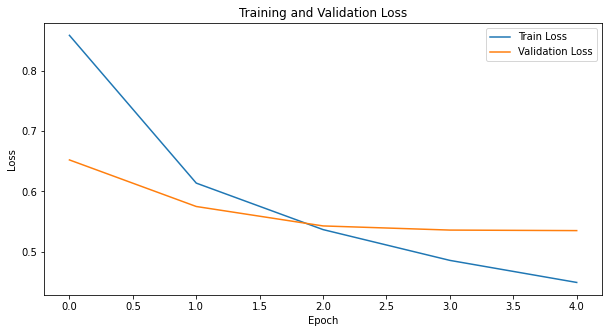

In [205]:
plt.figure(figsize=(10, 5))
plt.plot(hp_train_losses, label='Train Loss')
plt.plot(hp_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<span style='color:green'>
The graph shows that the model is learning well on the training data, as the training loss keeps going down steadily. However, the validation loss starts to flatten after a point, suggesting that the model might be struggling to improve on unseen data. This could be an early sign of overfitting, meaning the model is getting too good at the training set but not generalizing well enough. Adding techniques like early stopping or regularization might help it perform better on new data. 
</span>

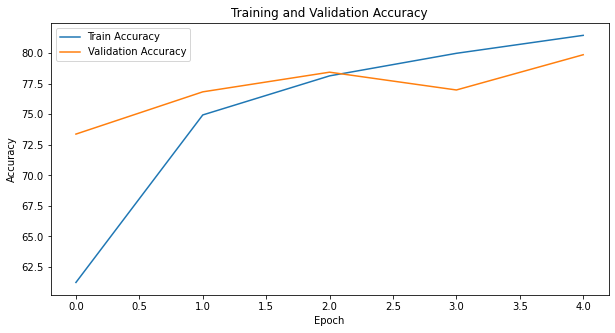

In [206]:
plt.figure(figsize=(10, 5))
plt.plot(hp_train_accuracies, label='Train Accuracy')
plt.plot(hp_val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<span style='color:green'>
The graph shows that both training and validation accuracies are improving over time, which means the model is learning well. However, the slight fluctuations in validation accuracy suggest that the model might be starting to overfit to the training data. The small gap between the two curves is a good sign, indicating that the model is handling new data reasonably well.
</span>

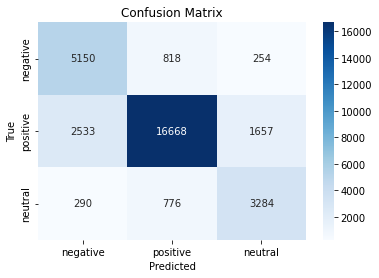

In [216]:
class_labels = df['sentiment'].unique()

hp_all_labels_np = np.array(hp_all_labels)
hp_all_preds_np = np.array(hp_all_preds)

cm = confusion_matrix(hp_all_labels_np, hp_all_preds_np)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<span style='color:green'>
The confusion matrix indicates that the model performs strongly in predicting the positive class, with a high count of correct predictions (16,668). While there are some misclassifications between negative and neutral classes, the overall accuracy appears reliable. With some additional fine-tuning, the model's ability to distinguish between these classes can likely be improved further.

</span>

4. Save the weights of the trained neural network

In [254]:
torch.save({"train_accuracy": hp_train_accuracies, "train_loss": hp_train_losses, "val_accuracy": hp_val_accuracies, "val_loss": hp_val_losses, "test_accuracy": hp_test_accuracy, "test_loss": hp_test_loss, "all_labels": hp_all_labels, "all_preds": hp_all_preds, "precision": hp_precision, "recall": hp_recall, "f1": hp_f1, "model_state": hp_model.state_dict()}, "a1_part4_base_dsivaram_svelmuru.pt")

## Step 3: Improved LSTM Model

1. Improve your baseline LSTM model

<span style='color:green'>
    
**Techniques used:**
    
* Bidirectional LSTM
* GRU (Gated Recurrent Unit)
    
</span>

In [220]:
batch_size = 64

In [221]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [222]:
class BidirectionalGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BidirectionalGRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout, bidirectional=True, batch_first=True)
        self.hidden_dim = hidden_dim * 2
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim)
        self.dropout = nn.Dropout(0.3)  
        self.relu = nn.ReLU()
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  
        gru_out, _ = self.gru(embedded)  
        gru_out = gru_out[:, -1, :] 
        gru_out = self.relu(gru_out)  
        gru_out = self.batch_norm(gru_out)  
        gru_out = self.dropout(gru_out)  
        out = self.fc(gru_out)  
        return out

# Hyperparameters
embedding_dim = 100
hidden_dim = 128  
output_dim = len(label_encoder.classes_)
num_layers = 3  
dropout = 0.3  
learning_rate = 0.0001  
batch_size = 64
num_epochs = 10

In [224]:
improved_model = BidirectionalGRUModel(len(vocab_nltk) + 1, embedding_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
summary(improved_model, input_size=(batch_size, max_length), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
BidirectionalGRUModel                    [64, 3]                   --
├─Embedding: 1-1                         [64, 17, 100]             7,618,000
├─GRU: 1-2                               [64, 17, 256]             769,536
├─ReLU: 1-3                              [64, 256]                 --
├─BatchNorm1d: 1-4                       [64, 256]                 512
├─Dropout: 1-5                           [64, 256]                 --
├─Linear: 1-6                            [64, 3]                   771
Total params: 8,388,819
Trainable params: 8,388,819
Non-trainable params: 0
Total mult-adds (G): 1.32
Input size (MB): 0.01
Forward/backward pass size (MB): 3.23
Params size (MB): 33.56
Estimated Total Size (MB): 36.80

2. Create a new class for your improved model

In [225]:
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(improved_model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [226]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time.time()
for epoch in range(num_epochs):
    improved_model.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = improved_model(images)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _,train_preds = torch.max(outputs,1)
        train_total += labels.size(0)
        train_correct += (train_preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    improved_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = improved_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _,val_preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_preds == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
#     scheduler.step(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")

Epoch [1/10], Train Loss: 1.0234, Train Accuracy: 51.48%, Validation Loss: 0.8492, Validation Accuracy: 66.14%
Epoch [2/10], Train Loss: 0.7876, Train Accuracy: 65.49%, Validation Loss: 0.7131, Validation Accuracy: 67.92%
Epoch [3/10], Train Loss: 0.6712, Train Accuracy: 70.82%, Validation Loss: 0.6609, Validation Accuracy: 69.63%
Epoch [4/10], Train Loss: 0.6080, Train Accuracy: 73.75%, Validation Loss: 0.6324, Validation Accuracy: 72.44%
Epoch [5/10], Train Loss: 0.5675, Train Accuracy: 75.25%, Validation Loss: 0.5997, Validation Accuracy: 74.15%
Epoch [6/10], Train Loss: 0.5327, Train Accuracy: 76.70%, Validation Loss: 0.5871, Validation Accuracy: 71.74%
Epoch [7/10], Train Loss: 0.5059, Train Accuracy: 77.53%, Validation Loss: 0.5898, Validation Accuracy: 77.72%
Epoch [8/10], Train Loss: 0.4847, Train Accuracy: 78.44%, Validation Loss: 0.5906, Validation Accuracy: 77.46%
Epoch [9/10], Train Loss: 0.4647, Train Accuracy: 79.09%, Validation Loss: 0.5813, Validation Accuracy: 77.33%
E

In [227]:
improved_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images,labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test_outputs = improved_model(images)
        loss = loss_function(test_outputs, labels)
        test_loss += loss.item()

        _, test_preds = torch.max(test_outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(test_preds.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (test_preds == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
test_precision = sklearn.metrics.precision_score(all_labels, all_preds, average='weighted')
test_recall = sklearn.metrics.recall_score(all_labels, all_preds, average='weighted')
test_f1_score = sklearn.metrics.f1_score(all_labels, all_preds, average='weighted')

print(f'Testing Accuracy: {test_accuracy:.2f}%')
print(f'Testing Loss: {test_loss:.4f}')
print(f'Testing Precision: {test_precision:.4f}')
print(f'Testing Recall: {test_recall:.4f}')
print(f'Testing F1 Score: {test_f1_score:.4f}')

Testing Accuracy: 77.46%
Testing Loss: 0.5758
Testing Precision: 0.8080
Testing Recall: 0.7746
Testing F1 Score: 0.7828


In [231]:
imp_train_accuracies = train_accuracies
imp_val_accuracies = val_accuracies
imp_train_losses = train_losses
imp_val_losses = val_losses
imp_test_accuracy = test_accuracy
imp_test_loss = test_loss
imp_model = model
imp_all_labels = all_labels
imp_all_preds = all_preds
imp_precision = test_precision
imp_recall = test_recall
imp_f1 = test_f1_score

3. Follow the same training and evaluation procedures

In [238]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def objective(trial):
    # Hyperparameter suggestions (using random search)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.3, 0.4, 0.5])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [5, 10, 15])

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Model, loss, and optimizer
    model = BidirectionalGRUModel(len(vocab_nltk) + 1, embedding_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training loop
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation accuracy for early stopping
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, val_preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Objective: minimize validation loss
    return val_loss

# Define study for random search
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=10)

# Best parameters and results
print(f"Best Validation Loss: {study.best_value}")
print(f"Best Hyperparameters: {study.best_params}")

[I 2025-03-07 02:16:15,157] A new study created in memory with name: no-name-af1d5934-230e-477c-99ac-3e95fac34deb
[I 2025-03-07 02:16:36,755] Trial 0 finished with value: 0.5816088320036245 and parameters: {'learning_rate': 0.0001895190563753867, 'hidden_size': 128, 'dropout_rate': 0.4, 'batch_size': 128, 'epochs': 5}. Best is trial 0 with value: 0.5816088320036245.
[I 2025-03-07 02:17:54,339] Trial 1 finished with value: 0.7700427952336102 and parameters: {'learning_rate': 0.0005238431318827998, 'hidden_size': 256, 'dropout_rate': 0.5, 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.5816088320036245.
[I 2025-03-07 02:18:16,043] Trial 2 finished with value: 0.5454532178194542 and parameters: {'learning_rate': 0.0004186280315726269, 'hidden_size': 128, 'dropout_rate': 0.3, 'batch_size': 128, 'epochs': 5}. Best is trial 2 with value: 0.5454532178194542.
[I 2025-03-07 02:22:02,703] Trial 3 finished with value: 0.7117635018683948 and parameters: {'learning_rate': 0.000171863

Best Validation Loss: 0.5375463421024927
Best Hyperparameters: {'learning_rate': 0.0005398511291342705, 'hidden_size': 64, 'dropout_rate': 0.4, 'batch_size': 128, 'epochs': 5}


In [239]:
train_loader = DataLoader(train_dataset, batch_size=study.best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=study.best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=study.best_params['batch_size'])

hp_imp_model = BaselineLSTM(len(vocab_nltk) + 1, embedding_dim, study.best_params['hidden_size'], output_dim, num_layers, study.best_params['dropout_rate']).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(hp_imp_model.parameters(), lr=study.best_params['learning_rate'], weight_decay=1e-5)


In [240]:
num_epochs = study.best_params['epochs']
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time.time()
for epoch in range(num_epochs):
    hp_imp_model.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = hp_imp_model(images)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _,train_preds = torch.max(outputs,1)
        train_total += labels.size(0)
        train_correct += (train_preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    hp_imp_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = hp_imp_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _,val_preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_preds == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
#     scheduler.step(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

end = time.time()
train_time = end - start
print(f"Training completed in: {train_time:.2f} seconds.")


Epoch [1/5], Train Loss: 0.8529, Train Accuracy: 60.79%, Validation Loss: 0.6653, Validation Accuracy: 70.30%
Epoch [2/5], Train Loss: 0.5991, Train Accuracy: 74.28%, Validation Loss: 0.5841, Validation Accuracy: 76.76%
Epoch [3/5], Train Loss: 0.5106, Train Accuracy: 77.88%, Validation Loss: 0.5595, Validation Accuracy: 73.24%
Epoch [4/5], Train Loss: 0.4552, Train Accuracy: 80.06%, Validation Loss: 0.5490, Validation Accuracy: 77.94%
Epoch [5/5], Train Loss: 0.4067, Train Accuracy: 81.84%, Validation Loss: 0.5612, Validation Accuracy: 78.19%
Training completed in: 17.77 seconds.


In [241]:
hp_imp_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images,labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test_outputs = hp_imp_model(images)
        loss = loss_function(test_outputs, labels)
        test_loss += loss.item()

        _, test_preds = torch.max(test_outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(test_preds.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (test_preds == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
test_precision = sklearn.metrics.precision_score(all_labels, all_preds, average='weighted')
test_recall = sklearn.metrics.recall_score(all_labels, all_preds, average='weighted')
test_f1_score = sklearn.metrics.f1_score(all_labels, all_preds, average='weighted')

print(f'Testing Accuracy: {test_accuracy:.2f}%')
print(f'Testing Loss: {test_loss:.4f}')
print(f'Testing Precision: {test_precision:.4f}')
print(f'Testing Recall: {test_recall:.4f}')
print(f'Testing F1 Score: {test_f1_score:.4f}')

Testing Accuracy: 78.17%
Testing Loss: 0.5632
Testing Precision: 0.8131
Testing Recall: 0.7817
Testing F1 Score: 0.7893


In [245]:
hp_imp_train_accuracies = train_accuracies
hp_imp_val_accuracies = val_accuracies
hp_imp_train_losses = train_losses
hp_imp_val_losses = val_losses
hp_imp_test_accuracy = test_accuracy
hp_imp_test_loss = test_loss
hp_imp_model = model
hp_imp_all_labels = all_labels
hp_imp_all_preds = all_preds
hp_imp_precision = test_precision
hp_imp_recall = test_recall
hp_imp_f1 = test_f1_score

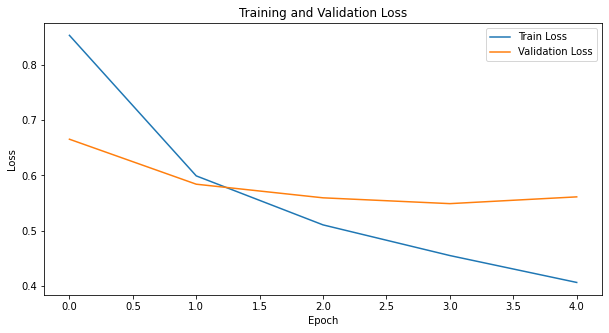

In [242]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<span style='color:green'>
The graph illustrates that the model is making good progress on the training data, as shown by the continuous drop in training loss. Meanwhile, the validation loss initially decreases but then starts to level off and even rise a bit, hinting that the model might be struggling to perform well on new data. This difference between training and validation losses suggests that the model could be overly focused on the training set. Introducing methods like dropout, regularization, or early stopping might help in balancing the performance.
</span>

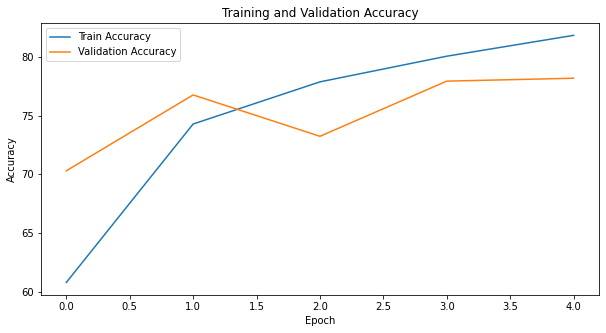

In [243]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<span style='color:green'>
The graph indicates that the model is learning effectively from the training data, as evidenced by the steady increase in training accuracy. However, the fluctuations in validation accuracy suggest that the model's generalization to unseen data could be enhanced. The widening gap between training and validation accuracies may point to early signs of overfitting, indicating that techniques such as regularization or early stopping could help improve the model's performance and stability. 
</span>

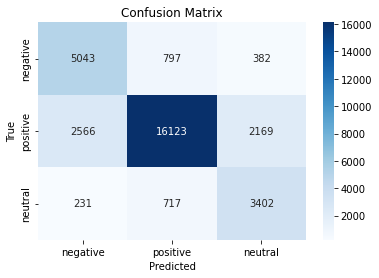

In [246]:
class_labels = df['sentiment'].unique()

hp_imp_all_labels_np = np.array(hp_imp_all_labels)
hp_imp_all_preds_np = np.array(hp_imp_all_preds)

cm = confusion_matrix(hp_imp_all_labels_np, hp_imp_all_preds_np)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<span style='color:green'>
The confusion matrix suggests that the model handles the positive class quite well, achieving a high number of correct predictions (16,123). Although there are some mistakes between the negative and neutral classes, the overall results look fairly balanced. Further fine-tuning might help the model improve its ability to tell these classes apart more accurately.
</span>

4. Directly compare the performance of your improved model to the baseline model

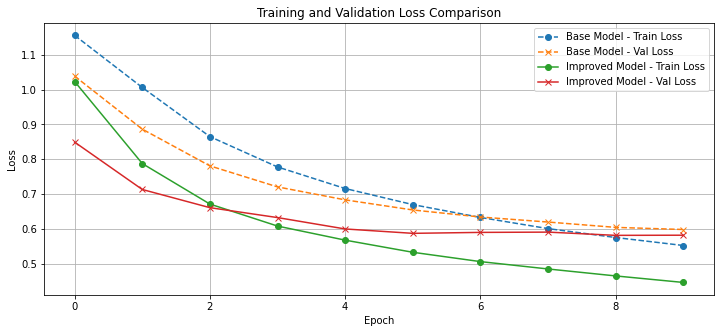

In [249]:
plt.figure(figsize=(12, 5))
plt.plot(base_train_losses, label='Base Model - Train Loss', linestyle='--', marker='o')
plt.plot(base_val_losses, label='Base Model - Val Loss', linestyle='--', marker='x')
plt.plot(imp_train_losses, label='Improved Model - Train Loss', linestyle='-', marker='o')
plt.plot(imp_val_losses, label='Improved Model - Val Loss', linestyle='-', marker='x')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

<span style='color:green'>The graph shows that the improved model outperforms the base model in terms of both training and validation loss, with a more rapid and consistent decline. The improved model's validation loss remains lower and more stable compared to the base model, suggesting better generalization to new data. The gap between training and validation losses for the improved model is also narrower, indicating reduced overfitting and a more balanced performance. Overall, these results suggest that the enhancements made to the model were effective.</span>

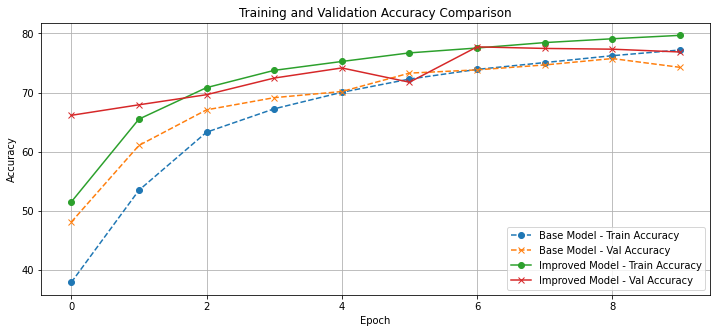

In [251]:
plt.figure(figsize=(12, 5))
plt.plot(base_train_accuracies, label='Base Model - Train Accuracy', linestyle='--', marker='o')
plt.plot(base_val_accuracies, label='Base Model - Val Accuracy', linestyle='--', marker='x')
plt.plot(imp_train_accuracies, label='Improved Model - Train Accuracy', linestyle='-', marker='o')
plt.plot(imp_val_accuracies, label='Improved Model - Val Accuracy', linestyle='-', marker='x')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

<span style='color:green'>The graph shows that the improved model consistently achieves higher accuracy than the base model for both training and validation sets. The improved model's validation accuracy remains stable and closely follows its training accuracy, indicating better generalization to unseen data. In contrast, the base model's validation accuracy lags behind, suggesting that the enhancements made to the improved model effectively boosted its performance and reduced the risk of overfitting.</span>

<span style='color:green'>
    
**Justification:**
    
* Bidirectional GRU: The use of bidirectional GRUs allowed the model to consider both past and future words in a sentence, enhancing its ability to understand context. This improvement in context awareness directly contributed to higher recall and accuracy by helping the model capture more relevant information.

* Efficiency of GRU: They have a simpler architecture compared to LSTMs, which makes them more efficient in learning patterns without becoming overly complex. This efficiency helped in reducing the loss and improving precision by making the model’s predictions more focused and reliable.

The combination of bidirectional processing and the efficiency of GRUs provided a balanced improvement across all metrics. This allowed the model to handle context more effectively while maintaining efficient and strong learning.

</span>

5. Save the weights of the trained neural network

In [253]:
### ADD YOUR CODE HERE ###
torch.save({"train_accuracy": hp_imp_train_accuracies, "train_loss": hp_imp_train_losses, "val_accuracy": hp_imp_val_accuracies, "val_loss": hp_imp_val_losses, "test_accuracy": hp_imp_test_accuracy, "test_loss": hp_imp_test_loss, "all_labels": hp_imp_all_labels, "all_preds": hp_imp_all_preds, "precision": hp_imp_precision, "recall": hp_imp_recall, "f1": hp_imp_f1, "model_state": hp_imp_model.state_dict()}, "a1_part4_improved_dsivaram_svelmuru.pt")
